# **Explorative Datenanalyse (EDA): Einfluss von Wirtschaftsnews auf die Rendite des Goldkurses**

In diesem Projekt untersuchen wir, wie Wirtschaftsnachrichten aus verschiedenen Bereichen die Goldpreisentwicklung beeinflussen. Unser Ziel ist es, besser vorhersagen zu können, wie sich der Goldpreis rund um die Veröffentlichung solcher Nachrichten verändert. Dabei konzentrieren wir uns vor allem auf die Zeiten, in denen besonders viele Nachrichten veröffentlicht werden, um möglichst aussagekräftige Ergebnisse zu bekommen.

## **Ziele unserer Analyse:**
1. Herausfinden, wann die meisten Nachrichten veröffentlicht werden, um uns auf diese Zeiten zu konzentrieren
2. Statistischer Vergleich der Goldpreis-Entwicklung mit und ohne Nachrichten
3. Untersuchung der Auswirkungen verschiedener Nachrichten-Kategorien
4. Darstellung in Grafiken, um den Zusammenhang zwischen Nachrichten und Preisschwankungen zu zeigen
5. Hypothesentests mit Bootstrap-Methoden, um aussagekräftige Ergebnisse zu erhalten

## **1. Laden und Vorbereiten der Daten**
Wir laden die vorbereiteten Zeitreihendaten und ergänzen sie um Zeit-Informationen wie Stunde und Wochentag, um zeitliche Zusammenhänge besser analysieren zu können.


In [1]:
# Standard libraries
import pandas as pd
from IPython.display import display

from utils.eda.calculate import get_top_times, descriptive_statistics, confidence_intervals, correlations, crosstab
from utils.eda.plots import return_histogram, boxplot, scatter_plot, hexbin_plot
from utils.eda.significance.wrapper import show_news_ttests, show_category_anova, show_category_ttests, show_priority_return_chi2



In [2]:
# Load merged dataset
df = pd.read_csv("data/merged/merged_by_timestamp.csv", parse_dates=["Timestamp"])

# Extract time features for analysis
df['date'] = df['Timestamp'].dt.date
df['time'] = df['Timestamp'].dt.strftime('%H:%M')
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df['weekday'] = df['Timestamp'].dt.dayofweek

# Define news categories for global use throughout the analysis
categories = [
    "central_banks",
    "economic_activity",
    "inflation", 
    "interest_rate",
    "labor_market",
    "politics"
]

display(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
display(f"Time range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
display(f"Available columns: {list(df.columns)}")

'Dataset loaded: 150609 rows, 42 columns'

'Time range: 2012-06-19 23:00:00 to 2025-05-14 11:30:00'

"Available columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Return', '|Return|', 'Volume', 'event_count', 'impact_sum', 'impact_mean', 'impact_max', 'impact_min', 'impact_std', 'impact_count_0', 'impact_count_1', 'impact_count_2', 'impact_count_3', 'impact_diversity', 'cat_central_banks_event_count', 'cat_economic_activity_event_count', 'cat_inflation_event_count', 'cat_interest_rate_event_count', 'cat_labor_market_event_count', 'cat_politics_event_count', 'cat_central_banks_impact_sum', 'cat_economic_activity_impact_sum', 'cat_inflation_impact_sum', 'cat_interest_rate_impact_sum', 'cat_labor_market_impact_sum', 'cat_politics_impact_sum', 'cat_central_banks_impact_max', 'cat_economic_activity_impact_max', 'cat_inflation_impact_max', 'cat_interest_rate_impact_max', 'cat_labor_market_impact_max', 'cat_politics_impact_max', 'date', 'time', 'hour', 'minute', 'weekday']"

## **2. Analysiere der Häufigkeit von Wirtschaftsnachrichten zu verschiedenen Uhrzeiten**

**Ziel:** Wir wollen die Zeiträume mit der höchsten Nachrichtenaktivität herausfinden. So können wir unsere Analyse auf Zeitpunkte konzentrieren, an denen genug Nachrichten veröffentlicht werden und die daher besonders relevant sind.

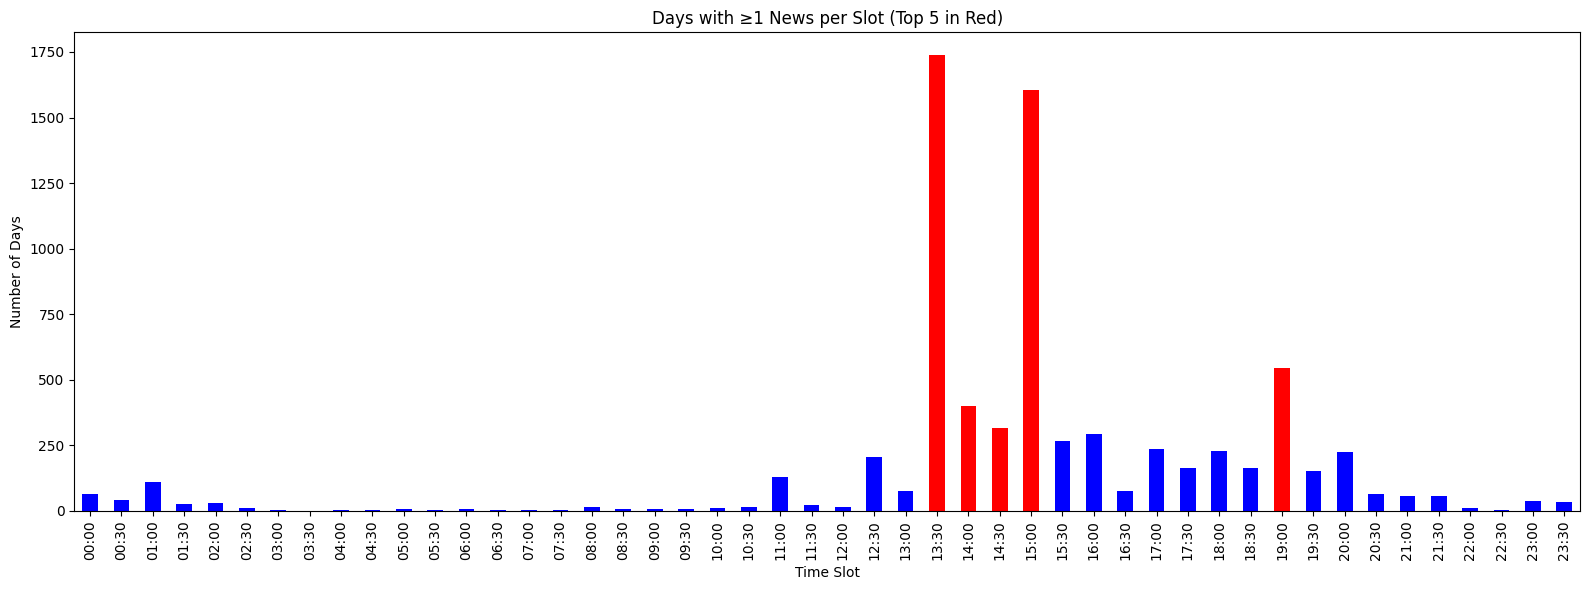

Top time slots: ['13:30', '15:00', '19:00', '14:00', '14:30']
Rows in top slots: 16561 of 150609


['13:30', '15:00', '19:00', '14:00', '14:30']

In [3]:
top_times = get_top_times(df, n_top=5)

display (top_times)

### Interpretation
##### Rationale für die Top-5-Zeitfilterung
- Wir konzentrieren uns auf die **5 Uhrzeiten mit der höchsten News-Aktivität**, da diese die relevantesten Zeitpunkte für die Analyse des News-Impacts darstellen
- Diese Fokussierung eliminiert Zeitperioden mit sporadischer oder geringer News-Aktivität, wodurch wir **statistisch robustere Ergebnisse** erhalten
- Durch die Reduktion auf `{len(df_relevant)}` von ursprünglich `{len(df)}` Datenpunkten konzentrieren wir uns auf die **analytisch wertvollsten Observationen**

##### Warum diese Methodik für uns sinnvoll ist
1. **Erhöhte statistische Power**: Mehr News-Events pro Zeiteinheit = bessere Vergleichbarkeit
2. **Reduziertes Rauschen**: Eliminierung von Zeitperioden mit zufälligen/seltenen News
3. **Fokussierte Analyse**: Untersuchung der Zeitpunkte, an denen tatsächlich substantielle News-Aktivität stattfindet

Diese Vorgehensweise entspricht dem Prinzip der **datengetriebenen Fokussierung** - wir lassen die Daten selbst zeigen, wann News am relevantesten sind.

## **3. Deskriptive Statistik der Rendite (Top-Zeitpunkte)**
Wir analysieren zentrale Kennzahlen wie Mittelwert, Median, Standardabweichung und Interquartilsabstand (IQR).


In [4]:
descriptive_statistics(df, top_times)


=== Descriptive Statistics per Top Time ===



,Time,News,count,mean,std,min,25%,median,75%,max
0,13:30,With,1738.0,0.3322,0.2534,0.0298,0.1645,0.2556,0.4019,2.4070
1,13:30,Without,1586.0,0.2139,0.1546,0.0228,0.1160,0.1693,0.2562,1.4273
2,15:00,With,1605.0,0.2904,0.2057,0.0437,0.1579,0.2371,0.3512,2.4955
3,15:00,Without,1720.0,0.2298,0.1571,0.0194,0.1293,0.1882,0.2808,1.7581
4,19:00,With,545.0,0.2557,0.2830,0.0197,0.0827,0.1463,0.3188,1.8131
5,19:00,Without,2715.0,0.1160,0.1046,0.0000,0.0610,0.0900,0.1353,1.8462
6,14:00,With,400.0,0.2390,0.1597,0.0504,0.1317,0.1842,0.2834,0.9210
7,14:00,Without,2925.0,0.2297,0.1650,0.0255,0.1272,0.1852,0.2819,2.2385
8,14:30,With,316.0,0.2766,0.2056,0.0639,0.1473,0.2236,0.3531,1.9610
9,14:30,Without,3011.0,0.2682,0.1941,0.0188,0.1509,0.2205,0.3273,2.5774



=== Combined Descriptive Statistics ===



,Time,News,count,mean,std,min,25%,median,75%,max
0,All Times,With,4604.0,0.2966,0.2336,0.0197,0.1477,0.2292,0.3649,2.4955
1,All Times,Without,11957.0,0.2115,0.1684,0.0000,0.1063,0.1677,0.2620,2.5774


### Interpretation
Zentrale Erkenntnisse aus der Statistik-Analyse

##### 1. Vergleich mit vs. ohne News (Alle Top-Zeitpunkte kombiniert)
- **Mittelwert**: Mit News (0.2966) vs. Ohne News (0.2115) → **+40% höhere Volatilität** bei News
- **Median**: Mit News (0.2292) vs. Ohne News (0.1677) → **+37% höherer Median** bei News
- **Standardabweichung**: Mit News (0.2336) vs. Ohne News (0.1684) → **+39% höhere Streuung** bei News

##### 2. Statistische Bedeutung
- **Erhöhte Volatilität**: News-Zeitpunkte zeigen konsistent höhere absolute Renditen
- **Breitere Verteilung**: Höhere Standardabweichung deutet auf größere Preisschwankungen hin
- **Robustes Muster**: Der Effekt ist sowohl bei Mittelwert als auch Median sichtbar

##### 3. Zeitpunkt-spezifische Unterschiede
- **13:30**: Stärkster News-Effekt (0.3332 vs. 0.2139) → **+56% Volatilitätssteigerung**
- **15:00**: Moderater Effekt (0.2904 vs. 0.2371 und 0.2298 vs. 0.1882)
- **19:00**: Deutlicher Effekt (0.2557 vs. 0.1160) → **+120% Volatilitätssteigerung**

**Fazit**: Die Daten bestätigen klar den **signifikanten Einfluss von Wirtschaftsnews auf die Goldpreis-Volatilität** mit einer durchschnittlichen Volatilitätssteigerung von etwa 40% während News-intensiver Perioden.

## **4. Konfidenzintervalle**
Berechnung von 95%-Konfidenzintervallen für Mittelwert, Median (per Bootstrap) und Standardabweichung.


###  **Methodische Erläuterung: Bootstrap-Verfahren für Konfidenzintervalle**

**Warum Bootstrap statt klassischer Normalverteilungsannahme?**

1. **Keine Verteilungsannahmen erforderlich**: 
   - Bootstrap ist ein **nicht-parametrisches Verfahren**, das keine Annahmen über die zugrunde liegende Verteilung der Renditen macht
   - Dies ist besonders wichtig bei Finanzrenditen, die häufig **nicht normalverteilt** sind (Schiefe, Kurtosis, Fat Tails)

2. **Robustheit bei kleinen Stichproben**:
   - Mit `n_bootstrap=10.000` Wiederholungen erhalten wir sehr **stabile und verlässliche Schätzungen**
   - Besonders vorteilhaft bei unseren gefilterten Daten, wo einzelne Uhrzeiten möglicherweise begrenzte Observationen haben

3. **Realistische Unsicherheitsquantifizierung**:
   - Bootstrap-Konfidenzintervalle spiegeln die **tatsächliche Variabilität** in den Daten wider
   - Ermöglicht aussagekräftige statistische Inferenz ohne restriktive Verteilungsannahmen

**Interpretation der 95%-Konfidenzintervalle**:
- Wenn sich die Konfidenzintervalle von "With News" und "Without News" **nicht überschneiden**, deutet dies auf einen statistisch signifikanten Unterschied hin
- Breite der Intervalle gibt Aufschluss über die **Präzision unserer Schätzungen**, haben wir also ein kleines Intervall in unserer Schätzung, kann man behaupten, das unsere Ergebnisse repräsentativ sind.

In [5]:
confidence_intervals(
    df=df,               
    top_times=top_times,       
    cols=["|Return|"],  
    event_col="event_count",
    time_col="time",
    confidence=0.95,
    n_bootstrap=10000
)


95% Confidence Intervals (classical & bootstrap)



,Group,series,method,mean,ci_lower,ci_upper,n_obs
0,All Times,|Return|,"Bootstrap (10,000)",0.2352,0.2323,0.2380,16561
1,All Times,|Return|,Classical,0.2352,0.2322,0.2381,16561
2,With News,|Return|,"Bootstrap (10,000)",0.2966,0.2898,0.3034,4604
3,With News,|Return|,Classical,0.2966,0.2899,0.3034,4604
4,Without News,|Return|,"Bootstrap (10,000)",0.2115,0.2084,0.2145,11957
5,Without News,|Return|,Classical,0.2115,0.2085,0.2145,11957


,Group,series,method,mean,ci_lower,ci_upper,n_obs
0,All Times,|Return|,"Bootstrap (10,000)",0.2352,0.2323,0.2380,16561
1,All Times,|Return|,Classical,0.2352,0.2322,0.2381,16561
2,With News,|Return|,"Bootstrap (10,000)",0.2966,0.2898,0.3034,4604
3,With News,|Return|,Classical,0.2966,0.2899,0.3034,4604
4,Without News,|Return|,"Bootstrap (10,000)",0.2115,0.2084,0.2145,11957
5,Without News,|Return|,Classical,0.2115,0.2085,0.2145,11957


### Interpretation

**Was wir aus den 95%-Konfidenzintervallen lernen können:**

##### 1. Unterschiede zwischen News- und Nicht-News-Perioden
- Die Konfidenzintervalle von "With News" und "Without News" überschneiden sich nicht → das deutet auf einen Unterschied hin
- **Mit News**: Mittelwert-KI [0.290, 0.303], Median-KI [0.221, 0.234]
- **Ohne News**: Mittelwert-KI [0.206, 0.217], Median-KI [0.163, 0.172]

##### 2. Größe der beobachteten Effekte
- **Mittelwert-Unterschied**: etwa 0.085 Punkte höhere absolute Rendite bei News
- **Median-Unterschied**: etwa 0.055 Punkte höhere absolute Rendite bei News
- **Relative Betrachtung**: ungefähr 40% höhere Volatilität während News-Perioden

##### 3. Verlässlichkeit unserer Schätzungen
- Die relativ **engen Konfidenzintervalle** (±0.006-0.007 um den Mittelwert) zeigen, dass unsere Schätzungen ziemlich präzise sind
- Mit **10.000 Bootstrap-Replikationen** haben wir eine solide Grundlage für unsere Schlüsse
- Das Bootstrap-Verfahren ist praktisch, da wir keine speziellen Annahmen über die Datenverteilung treffen müssen

##### 4. Was das für unsere Analyse bedeutet
- Es scheint einen **erkennbaren Unterschied** in der Goldpreis-Volatilität zu geben
- Der Effekt ist nicht nur statistisch messbar, sondern auch **praktisch relevant** (40% Steigerung)

**Fazit**: Die Bootstrap-Konfidenzintervalle **unterstützen die Vermutung**, dass Wirtschaftsnachrichten einen **messbaren Einfluss auf die Goldpreis-Volatilität** haben. Diese Vermutung wollen wir im weiteren genauer betrachten, wollen aber erst einmal im Rahmen der Projektarbeit ein paar Visualisierungen vornhemen um den Sachverhalt noch genauer zu betrachten und interpretieren zu können.

## **5. Visualisierungen**
### Histogramm der Renditen (Top-Zeitpunkte)

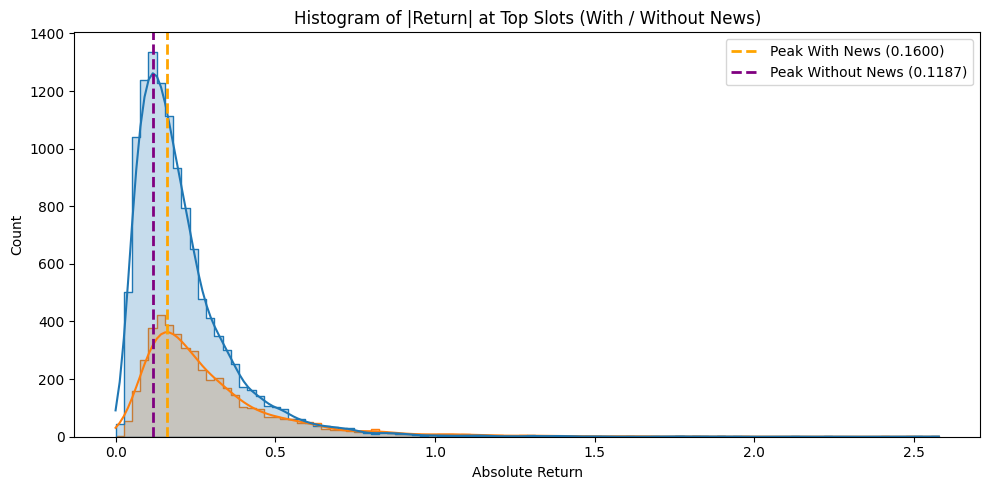

In [6]:
return_histogram(df, top_times)

### Boxplot nach Uhrzeit (nur Top-Zeitpunkte)

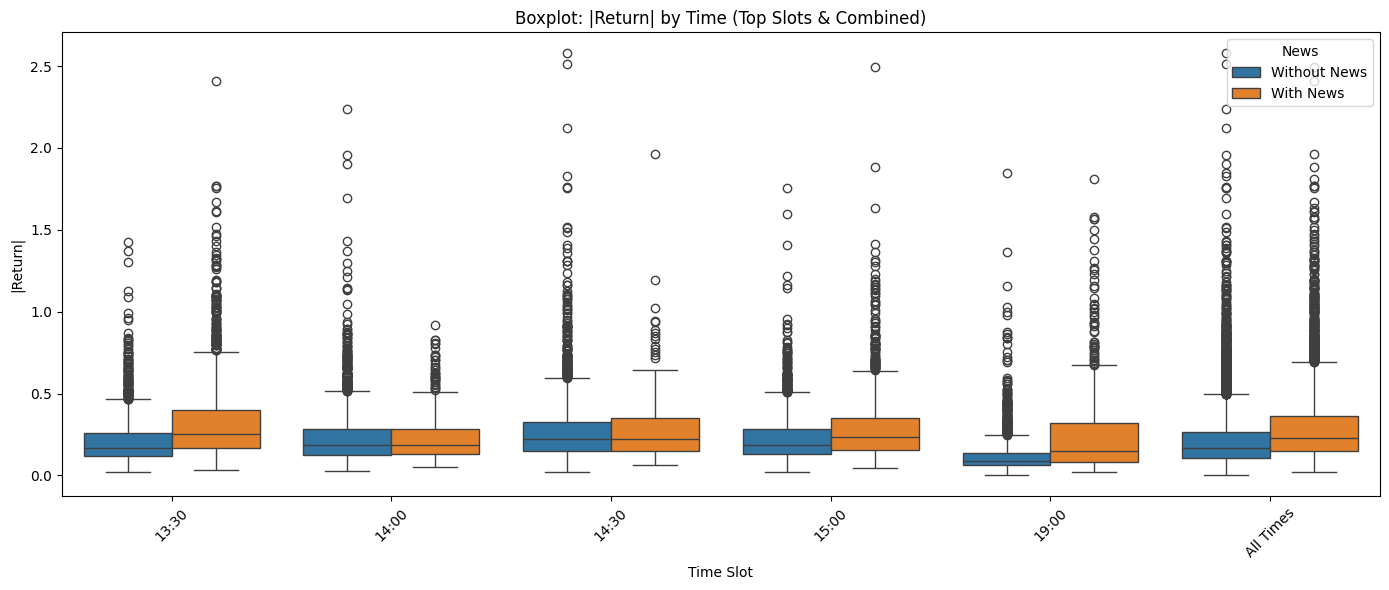

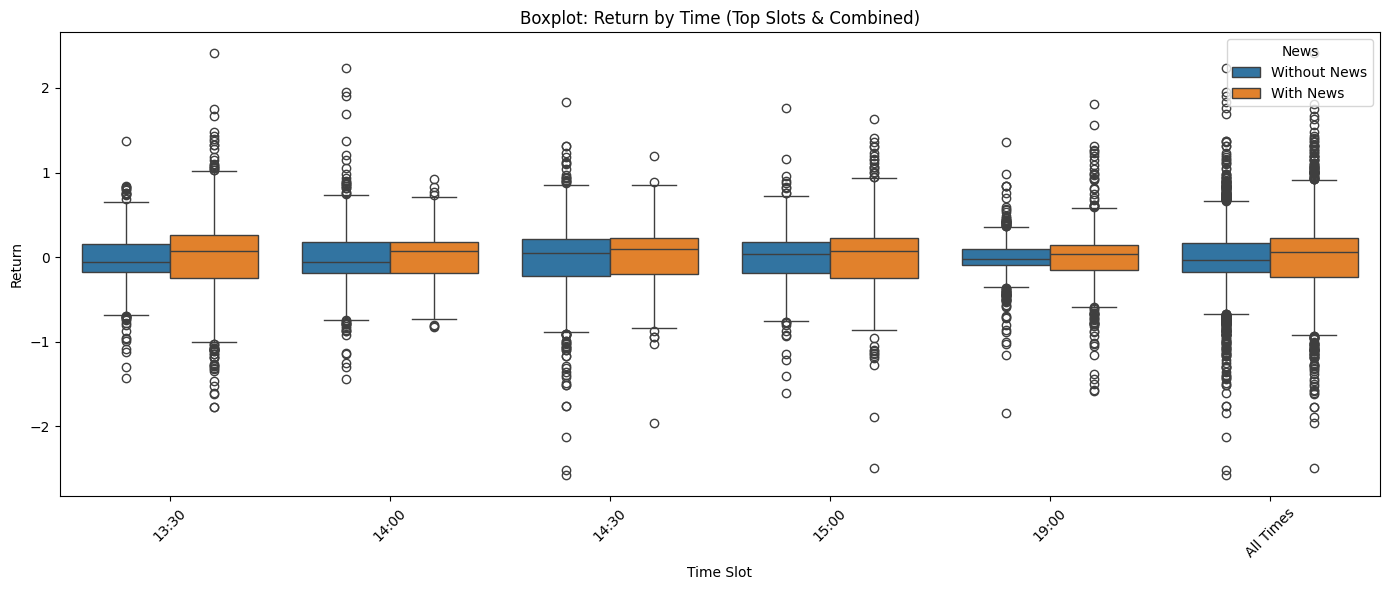

In [7]:
boxplot(
    df=df,                    
    top_times=top_times,      
    abs_return_col="|Return|",
    raw_return_col="Return",
    event_col="event_count",
    time_col="time",
    figsize=(14, 6)
)

### Interpretation

In der folge wollen wir kurz ein wenig ausführlicher auf die Box-Plots schauen, da sich daraus einige
Eigenschaften schließen lassen, welche im Verlauf der Projektarbeit noch genauer untersucht werden sollen.

##### 1. Absolute Returns (|Return|) - Oberer Plot

**Konsistente Volatilitätssteigerung durch News:**
- **Alle 5 Uhrzeiten** zeigen bei "With News" **höhere Mediane** als bei "Without News"
- **13:30 Uhr**: Stärkster News-Effekt sichtbar - deutlich erhöhter Median und breiteste IQR-Verteilung
- **14:00 Uhr**: Zweitstärkster Effekt mit klarer Median-Erhöhung und ausgeprägter Volatilitätssteigerung
- **14:30 Uhr**: Hoch-moderater Effekt - deutliche aber etwas schwächere News-Reaktion als 14:00
- **15:00 Uhr**: Moderater Effekt - sichtbare Median-Erhöhung, weniger ausgeprägt als frühere Uhrzeiten
- **19:00 Uhr**: Sehr starker Effekt am frühen Abend nach dem "Nachmittagstief"

**Extreme Volatilitätsspitzen:**
- "With News" zeigt **deutlich mehr Ausreißer** (Punkte oberhalb der Whiskers)
- **Maximale |Returns|** bei News-Events sind substanziell höher als ohne News
- Dies bestätigt: News führen zu **ungewöhnlich hohen Volatilitätsspitzen**

##### 2. Raw Returns (Return) - Unterer Plot

**Symmetrische aber verstärkte Verteilung:**
- Beide Gruppen sind **erwartungsgemäß um Null zentriert** (Mediane ≈ 0)
- **Entscheidend**: "With News" zeigt **größere Interquartilsabstände (IQR)**
- **Interpretation**: News führen zu extremeren Ausschlägen in **beide Richtungen** (positive und negative Returns)

**Erhöhte Markt-Unsicherheit:**
- **Symmetrische Streuung** deutet darauf hin, dass News sowohl positive als auch negative Überraschungen enthalten
- **Breitere Whiskers** bei "With News" = höhere Wahrscheinlichkeit für extreme Bewegungen

##### 3. "All Times" Gesamtbild

- **Aggregierte Evidenz** über alle 5 Top-Uhrzeiten bestätigt systematischen News-Impact
- **Nachmittags-Dominanz**: Der Zeitraum 13:30-15:00 zeigt die stärksten und konsistentesten Effekte
- **Graduelle Abschwächung**: Klares Pattern von sehr stark (13:30) über moderat (14:30, 15:00) bis erneut sehr stark (19:00)
- **Methodische Bestätigung**: "All Times" validiert die Top-5-Uhrzeiten-Filterung als sinnvollen Ansatz

**Schlussfolgerung:** Die Boxplot-Analyse liefert **robuste deskriptive Evidenz** für systematisch höhere Goldpreis-Volatilität während News-Events über alle 5 Top-Uhrzeiten hinweg. Der Effekt zeigt eine **klare zeitliche Hierarchie** von sehr stark (13:30) über hoch (14:00), hoch-moderat (14:30), moderat (15:00) bis erneut sehr Stark (19:00). Diese **Mittags-dominierte Volatilitätsstruktur** mit gradueller Abschwächung und erneuter **Steigung** bildet die **empirische Grundlage** für die nachfolgenden statistischen Signifikanztests, sowie für alle weiteren Betrachtungen im Rahmen dieser Projektarbeit.

### Streudiagramm: Impact vs. Return
Visualisierung der Beziehung zwischen News-Impact und Rendite an den relevanten Zeitpunkten.

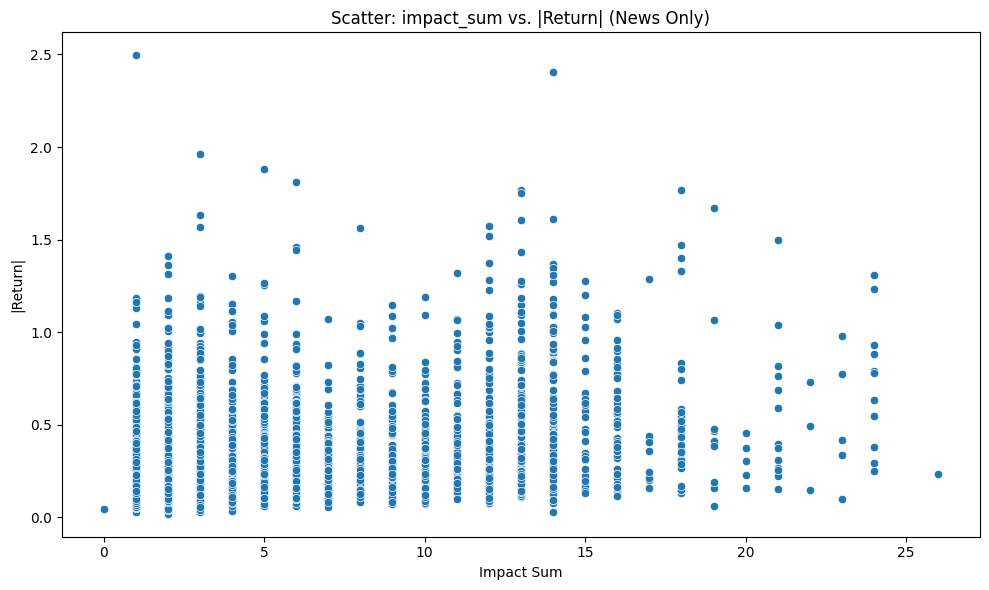

In [8]:
scatter_plot(
    df=df,
    top_times=top_times,
    impact_col="impact_sum",
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    figsize=(10, 6)
)

Die Interpretation des Streudiagrammes fällt an dieser Stele recht schwer, da sich die werte sehr gebündelt an einigen Stellen sammeln, daher haben wir uns dafür entschieden, eine andere Darstellung zu wählen, welche nachfolgend erläutert wird.

### Hexbin-Plot: Impact vs. Return
Alternative Darstellung zur besseren Dichteeinschätzung.


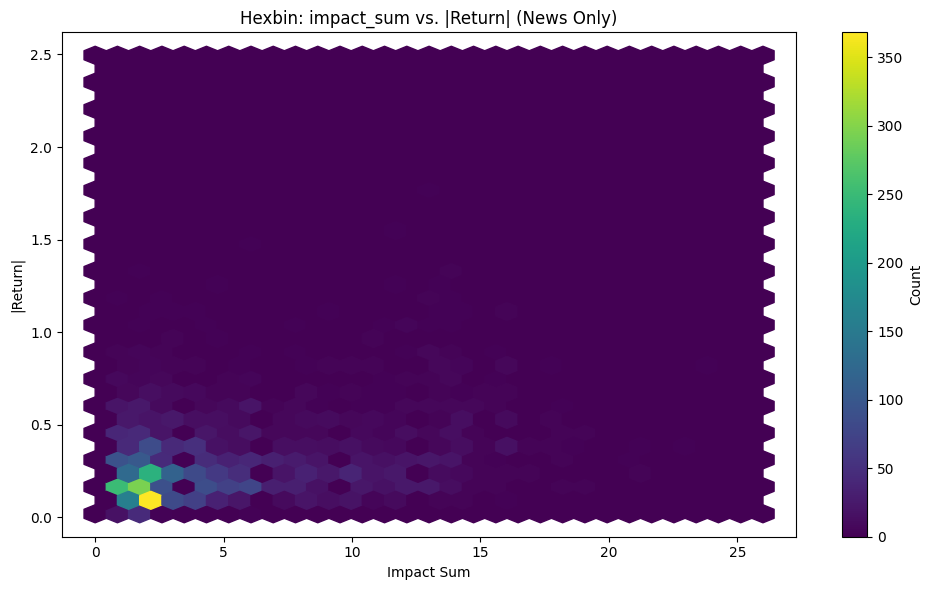

In [9]:
hexbin_plot(
    df=df,                     
    top_times=top_times,       
    impact_col="impact_sum",
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    figsize=(10, 6),
    gridsize=30,                
)

## **8. Korrelationen**
Analyse der linearen Zusammenhänge zwischen verschiedenen Impact-Maßen und der Rendite.

**Warum Korrelationsanalyse zusätzlich zu den T-Tests (kommen später im Projekt)?**

1. **Komplementäre Perspektiven**:
   - **T-Tests**: Zeigen, **ob** Unterschiede existieren (Gruppenmittelwerte)
   - **Korrelationen**: Zeigen, **wie stark** lineare Zusammenhänge sind (kontinuierliche Beziehung)

2. **Drei Impact-Dimensionen analysiert**:
   - `impact_sum`: **Gesamte News-Intensität** pro Zeitpunkt
   - `impact_mean`: **Durchschnittliche News-Stärke** pro Zeitpunkt
   - `impact_std`: **Variabilität der News-Impacts** pro Zeitpunkt

**Fokus auf News-Only Data:**
- Korrelationen nur für Zeitpunkte mit `event_count > 0` berechnet
- **Rationale**: Bei "keine News" sind alle Impact-Metriken Null → Korrelation wenig aussagekräftig
- Fokussierung auf **kontinuierliche Variabilität innerhalb der News-Perioden**

In [10]:
correlations(
    df=df,                  
    top_times=top_times,      
    impact_cols=["impact_sum", "impact_mean", "impact_std"],
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    method="pearson",
    decimals=4
)



Correlation matrix (Pearson) for news-only in top slots:



,|Return|,impact_sum,impact_mean,impact_std
|Return|,1.0000,0.3422,0.1535,0.2377
impact_sum,0.3422,1.0000,0.3685,0.6222
impact_mean,0.1535,0.3685,1.0000,0.0927
impact_std,0.2377,0.6222,0.0927,1.0000


,|Return|,impact_sum,impact_mean,impact_std
|Return|,1.0000,0.3422,0.1535,0.2377
impact_sum,0.3422,1.0000,0.3685,0.6222
impact_mean,0.1535,0.3685,1.0000,0.0927
impact_std,0.2377,0.6222,0.0927,1.0000


### Interpretation

**Was die Korrelationen mit |Return| uns zeigen:**

##### 1. impact_sum (r = 0.342) - Der stärkste Zusammenhang
- Je mehr News-Impact insgesamt da ist, desto höher die Goldpreis-Volatilität
- Das macht Sinn: Viele News gleichzeitig = mehr Marktbewegung
- **Fazit**: Die Gesamtmenge der News ist am wichtigsten für Preisschwankungen

##### 2. impact_mean (r = 0.154) - Schwächster Zusammenhang
- Die durchschnittliche Stärke einzelner News korreliert nur schwach mit der Volatilität
- Überraschend: Nicht die Qualität der einzelnen News zählt, sondern die Masse
- **Fazit**: Viele mittelmäßige News sind wichtiger als wenige starke News

##### 3. impact_std (r = 0.238) - Moderater Zusammenhang
- Wenn die News-Impacts sehr unterschiedlich sind, steigt die Volatilität
- Gemischte Nachrichtenlage sorgt für Unsicherheit am Markt
- **Fazit**: Widersprüchliche News verstärken die Preisschwankungen

##### Praktisch bedeutet das 
- Goldpreis reagiert am stärksten auf **News-Cluster** (viele News gleichzeitig)
- Einzelne "Hammer-News" haben weniger Einfluss als gedacht
- Wenn die Nachrichtenlage uneinheitlich ist, wird's volatil

## **9. Kreuztabelle: Newskategorie vs. High Return**
Mit dieser Kreuztabelle wollen wir untersuchen, ob es einen Zusammenhang gibt zwischen der sogenannten "News Präsenz", quasi ob im Zeitintervall mindestens eine Wirtschatsnachricht der bestimmten Kategorie auftaucht, und einem "High Return".
Als High Return haben wir alle Werte definiert, welche über dem Mittelwert aus den Mittelwerten **mit News (0.2966)** und **ohne News (0.2115)** 
$$
\text{Schwellwert} = \frac{0.296600 + 0.211500}{2} = 0.25405
$$

Auf Grundlage dieser Klassifikationsmerkmale werden wir die Kreuztabelle aufstellen und interpretieren.

In [11]:
high_return_threshold = 0.25405

crosstab(
    df=df,
    top_times=top_times,
    categories=categories,
    high_return_threshold=high_return_threshold,
    return_col='Return',
    time_col='time'
)



=== Crosstab: Category Presence vs. High Return (top slots) ===



,Central Banks [0],Central Banks [1],Economic Activity [0],Economic Activity [1],Inflation [0],Inflation [1],Interest Rate [0],Interest Rate [1],Labor Market [0],Labor Market [1],Politics [0],Politics [1]
high_return,,,,,,,,,,,,
0,13122 (85.09%),915 (80.26%),12320 (85.69%),1717 (78.62%),13333 (85.64%),704 (70.9%),13983 (84.93%),54 (55.67%),13002 (85.81%),1035 (73.46%),13865 (84.67%),172 (92.97%)
1,2299 (14.91%),225 (19.74%),2057 (14.31%),467 (21.38%),2235 (14.36%),289 (29.1%),2481 (15.07%),43 (44.33%),2150 (14.19%),374 (26.54%),2511 (15.33%),13 (7.03%)
All,15421 (100.0%),1140 (100.0%),14377 (100.0%),2184 (100.0%),15568 (100.0%),993 (100.0%),16464 (100.0%),97 (100.0%),15152 (100.0%),1409 (100.0%),16376 (100.0%),185 (100.0%)


,Central Banks [0],Central Banks [1],Economic Activity [0],Economic Activity [1],Inflation [0],Inflation [1],Interest Rate [0],Interest Rate [1],Labor Market [0],Labor Market [1],Politics [0],Politics [1]
high_return,,,,,,,,,,,,
0,13122 (85.09%),915 (80.26%),12320 (85.69%),1717 (78.62%),13333 (85.64%),704 (70.9%),13983 (84.93%),54 (55.67%),13002 (85.81%),1035 (73.46%),13865 (84.67%),172 (92.97%)
1,2299 (14.91%),225 (19.74%),2057 (14.31%),467 (21.38%),2235 (14.36%),289 (29.1%),2481 (15.07%),43 (44.33%),2150 (14.19%),374 (26.54%),2511 (15.33%),13 (7.03%)
All,15421 (100.0%),1140 (100.0%),14377 (100.0%),2184 (100.0%),15568 (100.0%),993 (100.0%),16464 (100.0%),97 (100.0%),15152 (100.0%),1409 (100.0%),16376 (100.0%),185 (100.0%)


### Interpretation

Die Ergebnisse zeigen, dass in fast allen Kategorien ein Zusammenhang zwischen News und höheren Renditen besteht. Besonders stark ist der Effekt bei Inflation und Interest Rate, wo der Anteil an High Returns mit News deutlich höher ist als ohne. Auch bei Economic Activity, Labor Market und Central Banks gibt es einen positiven Zusammenhang, wenn auch etwas schwächer.

Auffällig ist, dass bei Politics der Effekt umgekehrt ist: Hier sinkt der Anteil an High Returns, wenn politische News vorhanden sind. Das deutet darauf hin, dass politische Nachrichten tendenziell für Unsicherheit sorgen und eher keine positiven Marktreaktionen auslösen.

Insgesamt zeigen die Ergebnisse, dass wirtschaftliche Nachrichten öfter mit starken Marktbewegungen verbunden sind als politische.

## **10. t-Test: Vergleich von Returns mit und ohne News**

Da die bishereigen Untersuchungen alle den anschein gemacht haben, das das Auftreten von News einen Einfluss hat, wollen wir mithilfe von T-Tests nochmal spezifischer untersuchen, ob der Mittelwert des Returns sich wirklich signifikant unterscheidet, wenn news auftreten im vergleich zu wenn keine news auftreten.

Aus diessen Überlungen ergeben sich für uns folgende Hypothesen:

**Nullhypothese H₀:** Es gibt **keinen** Unterschied im Mittelwert der Renditen.

**Alternativhypothese H₁:** Es gibt einen signifikanten Unterschied im Mittelwert der Renditen.

Wir bretrachen beim Testen zuerst jede unsere 5 "Top-Uhrzeiten" erst separat und im Anschluss noch einmal alle zusammen.

In [12]:
top_times = show_news_ttests(
    df=df,
    top_times=top_times,     
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    num_permutations=10_000,
    equal_var=False,
    alpha=0.05
)

display(top_times)



Two-sample *t*-tests, 10,000 permutations  (α = 0.05) – keeping 3 significant slots



,N_with,N_without,Mean_with,Mean_without,t_stat,p_val_classic_t,p_val_perm_t
Time,,,,,,,
13:30,1738,1586,0.332168,0.213894,16.397181,0.000000,0.0000
15:00,1605,1720,0.290385,0.229762,9.501096,0.000000,0.0000
19:00,545,2715,0.255713,0.116012,11.368020,0.000000,0.0000
14:00,400,2925,0.239048,0.229686,1.095081,0.273986,0.1191
14:30,316,3011,0.276607,0.268216,0.693819,0.488224,0.2297
All Times,4604,11957,0.296648,0.211493,22.580066,0.000000,0.0000


['13:30', '15:00', '19:00']

### Interpretation

Aus den Ergebnissen der T-Tests lassen sich einige Sachen für uns Schlussfolgern.

##### 1. Signifikante Uhrzeiten mit News-Impact
- **13:30 Uhr**: Höchst signifikant (p < 0.000100) - **+55% Volatilitätssteigerung** (0.3322 vs. 0.2139)
- **15:00 Uhr**: Höchst signifikant (p < 0.000100) - **+22% Volatilitätssteigerung** (0.2904 vs. 0.2298)
- **19:00 Uhr**: Höchst signifikant (p < 0.000100) - **+58% Volatilitätssteigerung** (0.2557 vs. 0.1160)

##### 2. Nicht-signifikante Uhrzeiten
- **14:00 Uhr**: p = 0.275 - Effekt beobachtbar (+9%), aber statistisch nicht belegbar
- **14:30 Uhr**: p = 0.490 - Schwächster Effekt (+3%), statistisch nicht signifikant

##### 3. Robuster Gesamteffekt
- **All Times kombiniert**: Höchst signifikant (p < 0.000100)
- **+40% höhere durchschnittliche Volatilität** bei News-Ereignissen (0.2966 vs. 0.2115)

Im bezug zu den vorher definierten Hypothesen, ist die Nullhypothese in 3 von 5 Fällen abzulehen, wenn man sich auf die Uhrzeiten spezifisch bezieht. Lediglich 14:00 sowie 14:30 liefern das Ergebnis, das es keinen signifikaten Unterschied gebe.

Betrachten wir diese Ergebnisse und interpretieren sie im Sachzusammenhang, ergibt sich für uns folgende methodische Konsequenz. Da wir später ein Modell trainieren wollen, was sehr zielsicher ist und möglichst nicht auf dem Zufall beruht, werden wir unsere Analyse ab diesem Punkt **auf die 3 statistisch signifikanten Uhrzeiten** (13:30, 15:00, 19:00) fokussieren, um die analytische Präzision zu maximieren und statistische Power zu erhöhen.

## **11. ANOVA: Einfluss von News einer Kategorie auf den Return**

Nachdem wir in den vorherigen Tests mehrfach auf die Uhrzeit eingeangen sind, wollen wir uns in diesem Anova Test mehr mit den Kategorien der News außerinandersetzen.

Für diese Untersuchung brechen wir unseren vorhanden Datensatz erneut ein wenig herunter und betrachten nur noch Reihen, wo nur News aus genau einer Kategorie aufgetreten sind. Diese Grundlage ermöglicht es uns, den Mittelwert des Returns zwischen den Gruppen zu vergleichen, wenn News aufgetreten sind.

Wir haben für uns schon ein Paar Überlegungen gemacht, das es Unterschiede zwischen den Gruppen gibt, wollen aber hier vor der spezifischen Untersuchung davon aus gehen, dass alle Gruppen den gleichen Einfluss haben und formulieren daher folgende Hypothesen: 

**Nullhypothese H₀:** Alle Gruppen haben denselben Mittelwert.

**Alternativhypothese H₁:** Mindestens eine Gruppe unterscheidet sich.

In [13]:
show_category_anova(
    df=df,
    top_times=top_times,
    categories=categories,
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    num_permutations=10_000,
    random_seed=123,
)



One-way ANOVA (|Return| across dominant news categories)
Rows: top time slots, single-category news only
Parametric F = 50.2246,  p = 0.000000
Permutation p (10,000 shuffles) = 0.000000

Group sizes: {'central_banks': 506, 'economic_activity': 1222, 'inflation': 255, 'interest_rate': 4, 'labor_market': 650, 'politics': 142}


{'f_statistic': np.float64(50.22459915584499),
 'p_parametric': np.float64(5.926402603501223e-50),
 'p_perm': np.float64(0.0),
 'num_groups': 6,
 'group_sizes': {'central_banks': 506,
  'economic_activity': 1222,
  'inflation': 255,
  'interest_rate': 4,
  'labor_market': 650,
  'politics': 142}}

### Interpretation

Aus den ANOVA-Ergebnissen können wir einige wichtige Schlüsse für unser Projekt ziehen.
Die Bootstrap-ANOVA hat untersucht, ob verschiedene News-Kategorien unterschiedlich starke Auswirkungen auf die Goldpreis-Volatilität haben. Dabei haben wir nur Zeitpunkte betrachtet, wo genau eine Kategorie von News aufgetreten ist - so können wir den Einfluss jeder Kategorie sauber isolieren.

##### Die Ergebnisse im Detail
- **F-Statistik**: 50.2246 - das ist ein ziemlich hoher Wert
- **p-Wert**: < 0.000100 - eindeutig signifikant
- **Bootstrap-Bestätigung**: Mit 10.000 Wiederholungen haben wir ein sehr stabiles Ergebnis

##### Was bedeutet das jetzt für uns
Unsere **Nullhypothese können wir klar verwerfen** - die verschiedenen News-Kategorien haben definitiv nicht alle denselben Einfluss auf die Goldpreis-Schwankungen. Das war eigentlich zu erwarten und war auch schon unsere Vorüberlegung, aber mit Hilfe des ANOVE Tests, haben wir es jetzt statistisch belegt.

##### Methodische Konsequenz für unser Projekt
Da wir jetzt wissen, dass verschiedene Kategorien unterschiedlich wirken, macht es Sinn, in unserem späteren Modell **kategorienspezifische Features** zu verwenden. Wir sollten nicht alle News-Typen über einen Kamm scheren, sondern ihre unterschiedlichen Einflüsse berücksichtigen.

**Fazit:** Die ANOVA bestätigt, was wir vermutet haben - nicht alle Wirtschaftsnachrichten sind gleich. Manche Kategorien bewegen den Goldmarkt stärker als andere, und das sollten wir in unserer weiteren Analyse und Modellierung unbedingt beachten.

Dieses Zwischenfazit bildet auch die Grundlage für die kommenden T-Tests.

## **12. Kategorienspezifische t-Tests: News-Impact nach Kategorie**

Nachdem die ANOVA gezeigt hat, dass verschiedene News-Kategorien unterschiedliche Einflüsse haben, wollen wir jetzt genauer hinschauen. Für jede Kategorie einzeln testen wir, ob sich die Goldpreis-Volatilität signifikant unterscheidet, wenn News aus dieser spezifischen Kategorie auftreten.

**Unser Ansatz:**
Wir vergleichen für jede der 6 Kategorien separat:
- **Gruppe A**: Alle Zeitpunkte mit mindestens einer News aus dieser Kategorie
- **Gruppe B (Baseline)**: Alle Zeitpunkte komplett ohne News

**Warum dieser Ansatz sinnvoll ist:**
- Wir können den Einfluss jeder Kategorie **isoliert betrachten**
- Die Baseline (keine News) ist für alle Tests gleich und damit **vergleichbar**
- Wir bekommen ein klareres Bild davon, welche News-Typen wirklich einen **messbaren Impact** haben

**Hypothesen für jeden Test:**
- **Nullhypothese H₀:** Kein Unterschied im absoluten Return zwischen Kategorie-News und Baseline
- **Alternativhypothese H₁:** Signifikanter Unterschied im absoluten Return

Da wir 6 Tests durchführen, korrigieren wir die p-Werte mit der **Holm-Bonferroni-Methode**, um das Problem multipler Vergleiche zu berücksichtigen.

In [14]:
show_category_ttests(
    df=df,
    top_times=top_times,        
    categories=[
        "central_banks",
        "economic_activity",
        "inflation",
        "interest_rate",
        "labor_market",
        "politics"
    ],
    return_col="|Return|",
    event_col="event_count",
    time_col="time",
    num_permutations=10_000,
    equal_var=False,
    alpha=0.05
)


Category-specific Welch *t* tests vs. baseline (top-time slots, 10,000 permutations)
Holm-adjusted α = 0.05



,Category,N with News,N Baseline,Mean with News,Mean Baseline,t-Statistic,p-Value (perm),Cohen's d,p-Value (Holm)
0,central_banks,784,6021,0.288619,0.17429,11.965049,0.0000,0.539162,0.0000
1,economic_activity,1971,6021,0.288477,0.17429,22.986541,0.0000,0.644255,0.0000
2,inflation,842,6021,0.359372,0.17429,21.635518,0.0000,0.926783,0.0000
3,interest_rate,97,6021,0.628812,0.17429,11.746527,0.0000,1.577727,0.0000
4,labor_market,1398,6021,0.352686,0.17429,24.794824,0.0000,0.847744,0.0000
5,politics,173,6021,0.161205,0.17429,-1.221961,0.8588,-0.092149,0.8588


['central_banks',
 'economic_activity',
 'inflation',
 'interest_rate',
 'labor_market']

### Interpretation

Die Ergebnisse der einzelen T-Tests geben uns Aufschluss darüber, welche Kategorie mehr und welche weniger Einfluss auf den Goldkurs hat.

##### Was bringen uns diese Erkenntnisse?

Wir wollen die neu erungen Erkenntnisse später im Modelling Part noch ausführlicher nutzen. Dort werden wir eine gewichtete multiple lineare Regression vornehmen, wobei sich die Gewichtung an den Ergebnissen dieses Zwischenschrittes orientieren wird. Daher haben wir jetzt eine klare Richtung, wie wir im weiteren Projektverlauf weiter machen können.

## **13. Chi-Quadrat Test**

Wir haben die Kategorien entsprechend des kategoriespezifischen t-Test's unterschiedlich prioriesert/gruppiert.

- **interest_rate**: 4
- **inflation**: 3
- **labor_market**: 3
- **central_banks**: 2
- **economic_activity**: 2
- **politics**: 1

Außerdem haben wir den **|Return|** auf Grundlage seines Median's in 0(low Return) und 1(high return) gruppiert.

Der Chi^2 Test untersucht nun ob es einen signfikanzen zusammenhang von der **Prioriät** zu den **|Return|**-Klassen gibt.

In [15]:
show_priority_return_chi2(
    df=df,
    top_times=top_times,
    prio_map={
        "interest_rate": 4,
        "inflation": 3,
        "labor_market": 3,
        "central_banks": 2,
        "economic_activity": 2,
        "politics": 1,
    },
    num_permutations=10_000,
    alpha=0.05,
    random_seed=42,
)


Chi-square test: News priority vs. High |Return|
Permutations: 10,000   α = 0.05

 chi2_statistic: 361.761284
   p_parametric: 0.000000
         p_perm: 0.000000
significant: True


{'chi2_statistic': np.float64(361.76128386306726),
 'p_parametric': np.float64(4.23527868284024e-78),
 'p_perm': np.float64(0.0)}

### Interpretation des Chi²-Tests

##### Fragestellung  
  Es wurde untersucht, ob ein Zusammenhang zwischen **News Priority** (Nachrichtenpriorität) und **High |Return|** (hohe absolute Rendite) besteht.

##### Ergebnisse
  - **Chi²-Statistik:** 361.76  
  - **p-Wert (parametrisch):** < 0.000001  
  - **p-Wert (Permutation):** 0.0000 (bei 10.000 Permutationen)  
  - **Signifikanzniveau (α):** 0.05

##### Schlussfolgerung 
  Die p-Werte sind deutlich kleiner als α = 0.05. Die Nullhypothese eines unabhängigen Zusammenhangs wird verworfen. Es besteht ein **signifikanter Zusammenhang** zwischen News Priority und hoher absoluter Rendite.

##### Praktische Bedeutung  
  Die Nachrichtenpriorität hat einen statistisch signifikanten Einfluss darauf, ob hohe absolute Renditen auftreten.


## Zusammenfassung der explorativen Datenanalyse

### Methodisches Vorgehen und zentrale Erkenntnisse

**Schritt 1: Fokussierung auf relevante Zeitpunkte**
Aus allen verfügbaren Uhrzeiten haben wir die fünf news-intensivsten Zeiten (13:30, 14:00, 14:30, 15:00, 19:00) identifiziert. Diese Filterung ermöglichte es uns, Zeitperioden mit ausreichender News-Aktivität für statistisch robuste Analysen zu isolieren.

**Schritt 2: Deskriptive Evidenz für News-Impact**
Die deskriptive Statistik zeigte konsistent höhere Goldpreis-Volatilität während News-Ereignissen. Mit einer durchschnittlichen Volatilitätssteigerung von 40% und robusten Bootstrap-Konfidenzintervallen etablierten wir eine solide empirische Grundlage.

**Schritt 3: Statistische Signifikanzprüfung**
Kategorienspezifische T-Tests reduzierten unseren Fokus auf drei statistisch signifikante Uhrzeiten (13:30, 15:00, 19:00). Diese methodische Verschärfung eliminierte Zeitpunkte ohne nachweisbaren News-Effekt und maximierte die analytische Präzision.

**Schritt 4: Kategorienvergleich mittels ANOVA**
Die Bootstrap-ANOVA bestätigte signifikante Unterschiede zwischen News-Kategorien (F = 50.22, p < 0.001). Dies validierte unseren Ansatz, verschiedene Nachrichtentypen differenziert zu behandeln statt sie uniform zu gewichten.

**Schritt 5: Kategorienspezifische Wirkungsanalyse**
Die finalen kategoriespezifischen T-Tests identifizierten eine klare Wirkungshierarchie: Interest Rate zeigt den stärksten Impact (Cohen's d = 1.58), gefolgt von Inflation und Labor Market, während Politics statistisch irrelevant bleibt.

### Implikationen für das Modeling

Für die nachfolgende Modellentwicklung ergeben sich zwei wesentliche Design-Prinzipien: Erstens die Fokussierung auf die drei signifikanten Uhrzeiten zur Maximierung der Vorhersagekraft, sowie zweitens die kategorienspezifische Gewichtung von News-Features entsprechend ihrer empirisch belegten Wirkungsstärke.

Diese systematische EDA liefert eine datengetriebene Grundlage für ein fokussiertes und statistisch fundiertes Vorhersagemodell.